Cluster bias: category

Flat clustering (partitioning) -> clustering should be k-means

The cluster elements are document vectors

Extrinsic Eval: we are comparing the clusters vs ground truth (the categories)

Metrics:

Similarity between elements in a cluster

Homogeneity, Completeness and V-measure, Rand index, Adjusted Rand index, FowlkesMallows scores, Mutual information based scores ...

Even though silhouette coefficient is used for non-supervised clustering, we can check it to intuitively see if the models have difficulties bc the texts are two different. We could compare the silhouette scores for the diff text data used to see which one is more appropiate? 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib as plt 
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re

In [10]:
df = pd.read_csv(r"..\..\Web Scraped Corpus\physics_and_chemistry_nobel_laureate.csv")

In [39]:
df.head()

,year,name,country,category,biography,clean_biography
0,1901,Wilhelm Röntgen,German Empire,Physics,Wilhelm Conrad Röntgen (; German pronunciation...,Wilhelm Conrad Röntgen german pronunciation ˈv...
1,1902,Hendrik Lorentz,Netherlands,Physics,Hendrik Antoon Lorentz (; 18 July 1853 – 4 Feb...,Hendrik Antoon Lorentz July February dutch phy...
2,1902,Pieter Zeeman,Netherlands,Physics,Pieter Zeeman (Dutch: [ˈzeːmɑn]; 25 May 1865 –...,Pieter Zeeman Dutch ˈzeːmɑn October dutch phys...
3,1903,Henri Becquerel,France,Physics,Antoine Henri Becquerel (; French pronunciatio...,Antoine Henri Becquerel french pronunciation b...
4,1903,Pierre Curie,France,Physics,"Pierre Curie ( KURE-ee, French: [pjɛʁ kyʁi]; 1...",Pierre Curie KURE ee French pjɛʁ kyʁi April fr...


In [40]:
corpus = df["biography"].to_list()
print(len(corpus))

200


Preprocess to remove all the Wiki characters

In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [42]:
def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    clean_text = " ".join(tokens)
    return clean_text

In [43]:
df["clean"] = df["biography"].apply(clean_text)

<!-- Random idea: t-test for math characters -> justify whether we can use this regex for both categories -->

## Model

### Data splitting

In [103]:
from sklearn.model_selection import train_test_split

X = df["clean"].to_numpy()
y = df["category"].to_numpy()

In [104]:
# train_proportion = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

### Data vectorization

In [105]:
vectorizer = TfidfVectorizer(max_features=20,
                                       use_idf=True,
                                       stop_words='english',
                                       tokenizer=word_tokenize)

In [106]:
doc_vectors_train = vectorizer.fit_transform(X_train)
doc_vectors_test = vectorizer.transform(X_test)

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [107]:
vectorizer.get_feature_names_out()

array(['american', 'award', 'chemistry', 'einstein', 'institute',
       'laboratory', 'new', 'nobel', 'physics', 'prize', 'professor',
       'research', 'science', 'society', 'study', 'theory', 'time',
       'university', 'work', 'year'], dtype=object)

### Clustering

In [108]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=42)

In [109]:
km.fit(doc_vectors_train)

KMeans(n_clusters=2, n_init=5, random_state=42)

In [110]:
km.labels_

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0])

In [111]:
# would this be the actual way to get the predictions???

y_clusters_train = km.labels_.tolist()

In [112]:
y_pred = km.predict(doc_vectors_test)

In [113]:
y_pred

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

## Results

In [114]:
cluster_df_test = pd.DataFrame({"text": X_test, "target_category": y_test, "predicted_category": y_pred, "data_split":"test"})

In [115]:
cluster_df_train = pd.DataFrame({"text": X_train, "target_category": y_train, "predicted_category": y_clusters_train, "data_split":"train"})

In [116]:
cluster_df = pd.concat([cluster_df_test, cluster_df_train])

In [117]:
cluster_df[cluster_df["data_split"] == "train"]

,text,target_category,predicted_category,data_split
0,Linus Carl Pauling PAW ling February August am...,Chemistry,0,train
1,Lev Davidovich Landau Russian лев January Apri...,Physics,1,train
2,Christian Boehmer Anfinsen March american bioc...,Chemistry,0,train
3,Wilhelm Conrad Röntgen german pronunciation ˈv...,Physics,1,train
4,Max Born german pronunciation ˈmak ˈbɔʁn Decem...,Physics,1,train
...,...,...,...,...
155,Francis William Aston FRS September November b...,Chemistry,0,train
156,Pavel Alekseyevich Cherenkov Russian ˈpavʲɪl t...,Physics,1,train
157,Charles Hard Townes July January american phys...,Physics,1,train
158,Hideki Yukawa 湯川 秀樹 Yukawa Hideki January Sept...,Physics,1,train


In [118]:
cluster_df[cluster_df["data_split"] == "test"]

,text,target_category,predicted_category,data_split
0,Leopold Ružička croatian pronunciation rǔʒitʃk...,Chemistry,0,test
1,Carl David Anderson September January american...,Physics,1,test
2,Brian David Josephson bear January british the...,Physics,1,test
3,Sir Martin Ryle September October english radi...,Physics,1,test
4,Sir Arthur Harden FRS October June british bio...,Chemistry,0,test
5,Pierre Curie KURE ee French pjɛʁ kyʁi April fr...,Physics,1,test
6,Harold Clayton Urey YOOR ee April January amer...,Chemistry,0,test
7,Alexander Mikhailovich Prokhorov bear Alexande...,Physics,1,test
8,Polykarp Kusch January March German bear ameri...,Physics,1,test
9,William Nunn Lipscomb December April Nobel Pri...,Chemistry,0,test


Changing the prediction labels to be more readable

In [119]:
label_dictionary = {0:"Chemistry", 1:"Physics"}

In [120]:
cluster_df = cluster_df.replace(label_dictionary)

In [121]:
cluster_df[cluster_df["target_category"] != cluster_df["predicted_category"]]

,text,target_category,predicted_category,data_split
18,Viscount Ilya Romanovich Prigogine Russian Jan...,Chemistry,Physics,test
31,Walter Gilbert bear March american biochemist ...,Chemistry,Physics,test
48,Sir Aaron Klug August November british biophys...,Chemistry,Physics,train
65,Peter Joseph William Debye dutch dəˈbɛiə March...,Chemistry,Physics,train
85,Edwin Mattison McMillan September September am...,Chemistry,Physics,train
92,Gerhard Heinrich Friedrich Otto Julius Herzber...,Chemistry,Physics,train
116,Jean Frédéric Joliot Curie French fʁedeʁik ʒɔl...,Chemistry,Physics,train
159,Maria Salomea Skłodowska Curie Polish ˈmarja s...,Physics,Chemistry,train


### Metrics

In [122]:
y_test

array(['Chemistry', 'Physics', 'Physics', 'Physics', 'Chemistry',
       'Physics', 'Chemistry', 'Physics', 'Physics', 'Chemistry',
       'Physics', 'Physics', 'Chemistry', 'Physics', 'Chemistry',
       'Chemistry', 'Physics', 'Chemistry', 'Chemistry', 'Physics',
       'Chemistry', 'Physics', 'Physics', 'Physics', 'Physics', 'Physics',
       'Physics', 'Chemistry', 'Physics', 'Chemistry', 'Physics',
       'Chemistry', 'Chemistry', 'Chemistry', 'Chemistry', 'Chemistry',
       'Chemistry', 'Chemistry', 'Physics', 'Chemistry'], dtype=object)

In [123]:
y_pred

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [124]:
y_test

array(['Chemistry', 'Physics', 'Physics', 'Physics', 'Chemistry',
       'Physics', 'Chemistry', 'Physics', 'Physics', 'Chemistry',
       'Physics', 'Physics', 'Chemistry', 'Physics', 'Chemistry',
       'Chemistry', 'Physics', 'Chemistry', 'Chemistry', 'Physics',
       'Chemistry', 'Physics', 'Physics', 'Physics', 'Physics', 'Physics',
       'Physics', 'Chemistry', 'Physics', 'Chemistry', 'Physics',
       'Chemistry', 'Chemistry', 'Chemistry', 'Chemistry', 'Chemistry',
       'Chemistry', 'Chemistry', 'Physics', 'Chemistry'], dtype=object)

In [125]:
y_test = list(map(lambda x: x.replace("Chemistry","0").replace("Physics","1"), y_test))
y_test = np.array(y_test).astype(int)

In [131]:
y_train = list(map(lambda x: x.replace("Chemistry","0").replace("Physics","1"), y_train))
y_train = np.array(y_train).astype(int)

In [126]:
y_test

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [127]:
from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, y_pred))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, y_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, y_pred))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_test, y_pred))


Homogeneity: 0.758
Completeness: 0.764
V-measure: 0.761
Adjusted Rand-Index: 0.805


## Visualizations

In [243]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=2)

svd_vect_train = tsvd.fit_transform(doc_vectors_train.toarray())
svd_vect_test = tsvd.transform(doc_vectors_test.toarray())

# look into how much information we are losing reducing the dimensions

svd_test = pd.DataFrame(svd_vect_test)
svd_train = pd.DataFrame(svd_vect_train)

In [244]:
data_test = {"bio": X_test, "target_category": y_test, "predicted_category": y_pred, "data_split":"test"}
data_train = {"bio": X_train, "target_category": y_train, "predicted_category": np.array(y_clusters_train), "data_split":"train"}

df_svd_test = pd.DataFrame(data_test)
df_svd_train = pd.DataFrame(data_train)

In [245]:
df_svd_test = pd.concat([df_svd_test, svd_test], axis=1)
df_svd_train = pd.concat([df_svd_train, svd_train], axis=1)

In [246]:
df_svd_test = df_svd_test.replace(label_dictionary)
df_svd_train = df_svd_train.replace(label_dictionary)

In [247]:
df_svd_train.columns

Index(['bio', 'target_category', 'predicted_category', 'data_split', 0, 1], dtype='object')

In [248]:
def accurate_cat(df):
    df["correct"] = None
    for index in df.index:
        target = df["target_category"][index]
        predicted = df["predicted_category"][index]
        # print(target, predicted)
        if target == predicted:
            df["correct"][index] = "Correct"
        else:
            
            df["correct"][index] = f"Predicted: {predicted}\n Correct: {target}"
    return df

In [249]:
df_svd_train = accurate_cat(df_svd_train)
df_svd_test = accurate_cat(df_svd_test)

C:\Users\alber\AppData\Local\Temp\ipykernel_12312\433265733.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alber\AppData\Local\Temp\ipykernel_12312\433265733.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alber\AppData\Local\Temp\ipykernel_12312\433265733.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alber\AppData\Local\Temp\ipykernel_12312\433265733.py:8: SettingWithCopyWarning:


A value is 

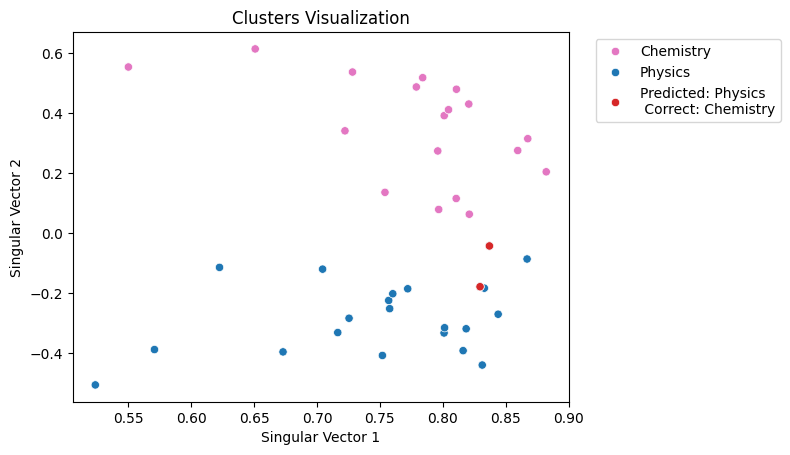

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.scatterplot(
    df_svd_test,
    x = 0,
    y = 1,
    hue="predicted_category",
    palette=["C6", "C40"]
)


incorrect_df = df_svd_test[df_svd_test["correct"] != "Correct"]
sns.scatterplot(
        incorrect_df,
        x = 0,
        y = 1,
        hue="correct", 
        palette=["C2333"],
)

plt.title("Clusters Visualization")
plt.xlabel("Singular Vector 1")
plt.ylabel("Singular Vector 2")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()